In [57]:
import pandas as pd
from scipy import stats
import numpy as np
from scipy.stats import wilcoxon

In [5]:
file_path = '/Users/harriethe/Downloads/Questioneer.xlsx'
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

In [7]:
df_new = pd.read_csv('/Users/harriethe/Downloads/Question_new.csv')

In [9]:
# 1. Remove rows where Timepoint is '0'
df_cleaned = df_new[df_new['Timepoint relative to drug administration (in minutes)'] != '0']

# 2. Replace 'baseline' with 0 in the Timepoint column
df_cleaned['Timepoint relative to drug administration (in minutes)'] = df_cleaned['Timepoint relative to drug administration (in minutes)'].replace('baseline', 0)

df_cleaned = df_cleaned[df_cleaned['Timepoint relative to drug administration (in minutes)'] != 'Avg from capsule to 360']
# 3. Replace 'ms' (missing) values with NaN throughout the entire DataFrame
df_cleaned = df_cleaned.replace('ms', np.nan)

df_cleaned['Timepoint relative to drug administration (in minutes)'] = pd.to_numeric(df_cleaned['Timepoint relative to drug administration (in minutes)'], errors='coerce')

timepoints = df_cleaned['Timepoint relative to drug administration (in minutes)'].unique()
print(timepoints)

[  0  30  60 120 180 240 300 360]


/var/folders/fh/_crmyvv94rjbbn8m0gv12w2r0000gn/T/ipykernel_21055/2506174059.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Timepoint relative to drug administration (in minutes)'] = df_cleaned['Timepoint relative to drug administration (in minutes)'].replace('baseline', 0)


In [69]:
rating_columns = [
    '1. Overall Psilocybin Effect (0 = none to\n10 = strongest imaginable)',
    '2. Now-ness (0 = none to\n10 = strongest imaginable)',
    '3. Letting Go (0 = none to\n10 = strongest imaginable)',
    '4. Equanimity (0 = none to\n10 = strongest imaginable)',
    '5. Pure being and pure awareness (0 = none to\n10 = strongest imaginable)',
    '6. Fusion of your personal self into a larger whole (0 = none to\n10 = strongest imaginable)',
    '7. Sense of reverence or sacredness (0 = none to\n10 = strongest imaginable)',
    '8. Timelessness (0 = none to\n10 = strongest imaginable)',
    '9. Ineffability (0 = none to\n10 = strongest imaginable)',
    '10. Feelings of joy (0 = none to\n10 = strongest imaginable)',
    '11. Feelings of peace and tranquility (0 = none to\n10 = strongest imaginable)',
    '12. Positive Emotional Valence (0 = none to\n10 = strongest imaginable)',
    '13. Negative emotional valence  (0 = none to\n10 = strongest imaginable)'
]

m = len(rating_columns)

In [17]:
df_cleaned.columns = df_cleaned.columns.str.strip()
#print(df_filtered.columns)

df_cleaned[rating_columns] = df_cleaned[rating_columns].apply(pd.to_numeric, errors='coerce')

# Check if the conversion worked by printing the dtypes
#print(df_filtered[rating_columns].dtypes)

## Sections for Pair T Test

In [19]:
from scipy import stats

# Prepare dictionaries to store results for each time point
paired_results_by_time = {}

# Loop through each timepoint
for timepoint in timepoints:
    # Filter data for the current timepoint
    df_timepoint = df_cleaned[df_cleaned['Timepoint relative to drug administration (in minutes)'] == timepoint]
    
    # Filter for placebo and psilocybin participants
    placebo_scores = df_timepoint[df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA'][rating_columns]
    exp_scores = df_timepoint[df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'EXP'][rating_columns]

    # Initialize a dictionary to hold t-test results for this time point
    paired_results_by_time[timepoint] = {}

    # Perform paired t-test for each question (rating column)
    for col in rating_columns:
        if len(placebo_scores[col]) == len(exp_scores[col]) and len(placebo_scores[col]) > 0:  # Ensure valid data
            t_stat, p_value = stats.ttest_rel(placebo_scores[col], exp_scores[col], nan_policy='omit')
            # Transform p-values using -log10(p-value) if p-value > 0
            log_p_value = -np.log10(p_value) if p_value > 0 else None
            paired_results_by_time[timepoint][col] = (t_stat, log_p_value)  # Store log-transformed p-value
        else:
            paired_results_by_time[timepoint][col] = (None, None)  # In case of insufficient or unequal data

    # Print the results for this timepoint
    print(f"Results for Timepoint {timepoint} (minutes):")
    for col, (t_stat, log_p_value) in paired_results_by_time[timepoint].items():
        print(f"{col}: T-statistic = {t_stat}, -log10(P-value) = {log_p_value}")
    print("\n")

Results for Timepoint 0 (minutes):
1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): T-statistic = nan, -log10(P-value) = None
2. Now-ness (0 = none to
10 = strongest imaginable): T-statistic = 0.18797789509922808, -log10(P-value) = 0.06915886514948631
3. Letting Go (0 = none to
10 = strongest imaginable): T-statistic = -0.7056967961720457, -log10(P-value) = 0.31112136557311854
4. Equanimity (0 = none to
10 = strongest imaginable): T-statistic = -0.9687189593929654, -log10(P-value) = 0.46311943112020176
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): T-statistic = 0.6913837373523726, -log10(P-value) = 0.3034058432732242
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): T-statistic = 0.657595949221429, -log10(P-value) = 0.2854227198691093
7. Sense of reverence or sacredness (0 = none to
10 = strongest imaginable): T-statistic = 0.10347288589592778, -log10(P-value) = 0.0368649478147384
8. Timelessnes

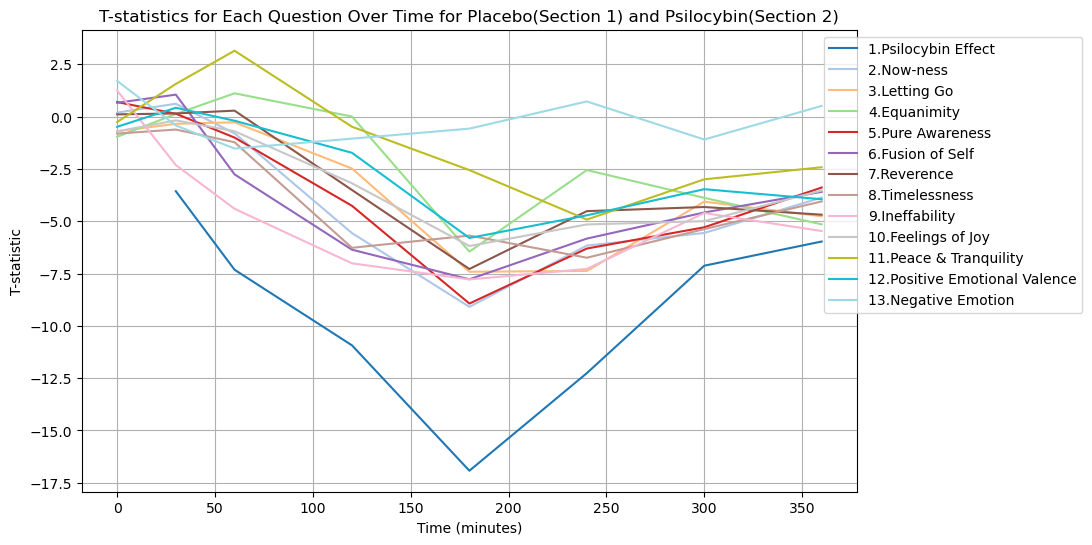

In [21]:
import matplotlib.pyplot as plt

shortened_rating_columns = [
    '1.Psilocybin Effect', '2.Now-ness', '3.Letting Go', '4.Equanimity', '5.Pure Awareness', 
    '6.Fusion of Self', '7.Reverence', '8.Timelessness', '9.Ineffability', 
    '10.Feelings of Joy', '11.Peace & Tranquility', '12.Positive Emotional Valence', '13.Negative Emotion'
]

timepoints = list(paired_results_by_time.keys())
t_stats_by_question = {col: [] for col in rating_columns}

# Populate the t-statistics for each question at each timepoint
for timepoint in timepoints:
    for col in rating_columns:
        t_stat, _ = paired_results_by_time[timepoint][col]
        t_stats_by_question[col].append(t_stat)

# Plot t-statistics for each question as a line plot
plt.figure(figsize=(10, 6))
#for col in rating_columns:
    #plt.plot(timepoints, t_stats_by_question[col], label=col)
cmap = plt.get_cmap('tab20', len(shortened_rating_columns))

for i,(col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, t_stats_by_question[col], label=short_col,color=cmap(i))
plt.xlabel('Time (minutes)')
plt.ylabel('T-statistic')
plt.title('T-statistics for Each Question Over Time for Placebo(Section 1) and Psilocybin(Section 2)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()

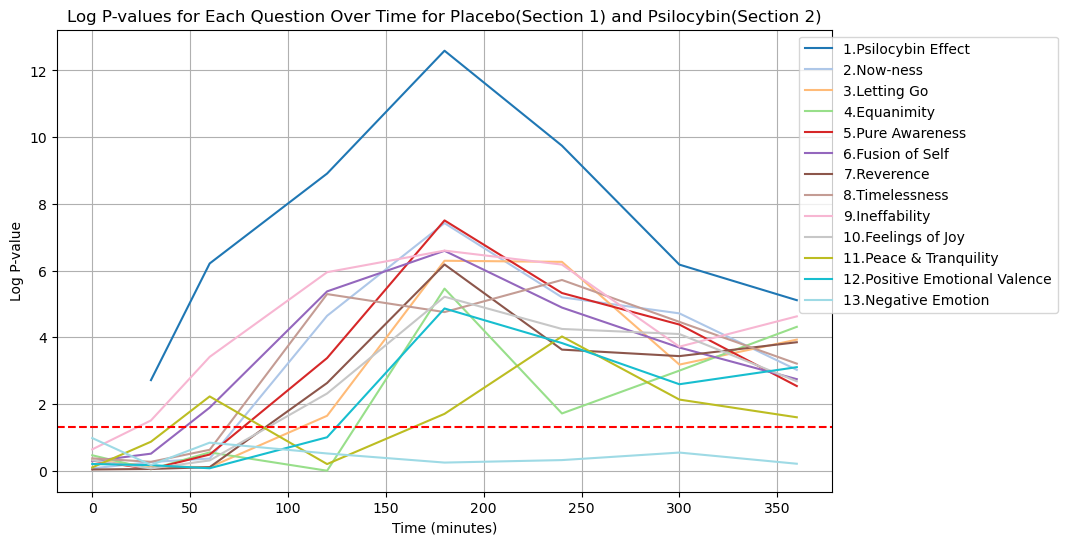

In [23]:
log_p_values_by_question = {col: [] for col in rating_columns}

for timepoint in timepoints:
    for col in rating_columns:
        _, log_p_value = paired_results_by_time[timepoint][col]
        log_p_values_by_question[col].append(log_p_value)

# Plot p-values for each question as a line plot
plt.figure(figsize=(10, 6))
#for col in rating_columns:
    #plt.plot(timepoints, p_values_by_question[col], label=col)
for i,(col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, log_p_values_by_question[col], label=short_col,color=cmap(i))
plt.xlabel('Time (minutes)')
plt.ylabel('Log P-value')
plt.title('Log P-values for Each Question Over Time for Placebo(Section 1) and Psilocybin(Section 2)')
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--')  
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()

## This Section is for Wilcoxon ##

Wilcoxon is not good with NaN

In [88]:
df_cleaned_imputed = df_cleaned.copy()
#df_cleaned_imputed[rating_columns] = df_cleaned_imputed[rating_columns].fillna(method='ffill')
#print("NaN: ",df_cleaned_imputed.isnull().sum())
if all(col in df_cleaned_imputed.columns for col in rating_columns):
    df_cleaned_imputed[rating_columns] = df_cleaned_imputed[rating_columns].fillna(method='ffill')
else:
    print("Some columns in rating_columns are not found in the DataFrame.")

print("NaN: ", df_cleaned_imputed.isnull().sum())
for timepoint in timepoints:
    df_timepoint = df_cleaned_imputed[df_cleaned_imputed['Timepoint relative to drug administration (in minutes)'] == timepoint]
    print(f"Missing values for Timepoint {timepoint} (minutes):")
    print(df_timepoint[rating_columns].isna().sum())  # Use df_timepoint to check missing values for the specific timepoint

# Drop rows with missing values for the specific columns
df_cleaned_imputed[rating_columns] = df_cleaned_imputed[rating_columns].fillna(method='ffill')
print("NaN: ", df_cleaned_imputed.isnull().sum())

NaN:  Volunteer number                                                                                  0
Session (1, 2)                                                                                    0
Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)                                              0
Timepoint relative to drug administration (in minutes)                                            0
1. Overall Psilocybin Effect (0 = none to\n10 = strongest imaginable)                             0
2. Now-ness (0 = none to\n10 = strongest imaginable)                                              0
3. Letting Go (0 = none to\n10 = strongest imaginable)                                            0
4. Equanimity (0 = none to\n10 = strongest imaginable)                                            0
5. Pure being and pure awareness (0 = none to\n10 = strongest imaginable)                         0
6. Fusion of your personal self into a larger whole (0 = none to\n10 = strongest imaginable)  

In [100]:
m = len(rating_columns)  # Number of comparisons for Bonferroni correction

for timepoint in timepoints:
    # Filter data for the current timepoint
    df_timepoint = df_cleaned_imputed[df_cleaned_imputed['Timepoint relative to drug administration (in minutes)'] == timepoint]
    
    # Filter for placebo and psilocybin participants
    placebo_scores = df_timepoint[df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA'][rating_columns]
    exp_scores = df_timepoint[df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'EXP'][rating_columns]

    # Initialize a dictionary to hold Wilcoxon test results for this time point
    paired_results_by_time[timepoint] = {}

    # Perform Wilcoxon signed-rank test for each question (rating column)
    for col in rating_columns:
        if len(placebo_scores[col]) == len(exp_scores[col]) and len(placebo_scores[col]) > 0:  # Ensure valid data
            try:
                # Perform Wilcoxon signed-rank test
                t_stat, p_value = wilcoxon(placebo_scores[col], exp_scores[col], zero_method='wilcox', correction=False)
                
                # Apply Bonferroni correction
                bonferroni_p_value = p_value * m
                if bonferroni_p_value > 1:  # Ensure that p-value doesn't exceed 1
                    bonferroni_p_value = 1

                # Use a tiny threshold to avoid zero p-values
                tiny_threshold = 1e-14
                # Transform p-values using -log10(p-value) with the tiny threshold for small p-values
                log_bonferroni_p_value = -np.log10(max(bonferroni_p_value, tiny_threshold))
                
                paired_results_by_time[timepoint][col] = (t_stat, log_bonferroni_p_value)  # Store log-transformed p-value
            except ValueError:
                # Handle case where Wilcoxon test cannot be computed (e.g., all zero differences)
                paired_results_by_time[timepoint][col] = (None, None)
        else:
            paired_results_by_time[timepoint][col] = (None, None)  # In case of insufficient or unequal data

    # Print the results for this timepoint
    print(f"Results for Timepoint {timepoint} (minutes):")
    for col, (t_stat, log_bonferroni_p_value) in paired_results_by_time[timepoint].items():
        print(f"{col}: Wilcoxon statistic = {t_stat}, -log10(Bonferroni P-value) = {log_bonferroni_p_value}")
    print("\n")

/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.


Results for Timepoint 0 (minutes):
1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): Wilcoxon statistic = None, -log10(Bonferroni P-value) = None
2. Now-ness (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 37.5, -log10(Bonferroni P-value) = -0.0
3. Letting Go (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 74.0, -log10(Bonferroni P-value) = -0.0
4. Equanimity (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 59.5, -log10(Bonferroni P-value) = -0.0
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 43.5, -log10(Bonferroni P-value) = -0.0
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 33.5, -log10(Bonferroni P-value) = -0.0
7. Sense of reverence or sacredness (0 = none to
10 = strongest imaginable): Wilcoxon statistic = 74.0, -log10(Bonferroni P-value) = -0.0
8. Timelessness (0 = none to
10 = strongest imaginable): Wilc

/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/harriethe/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


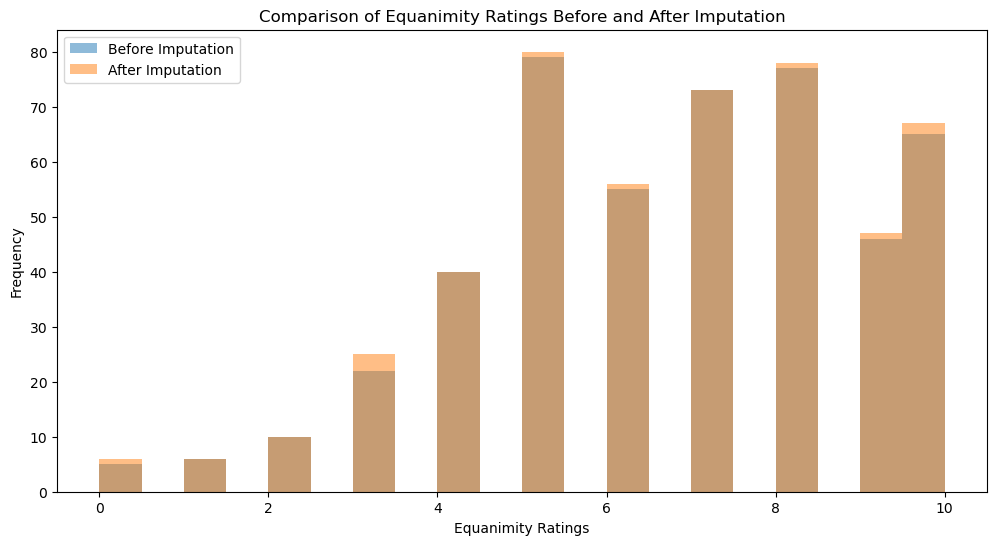

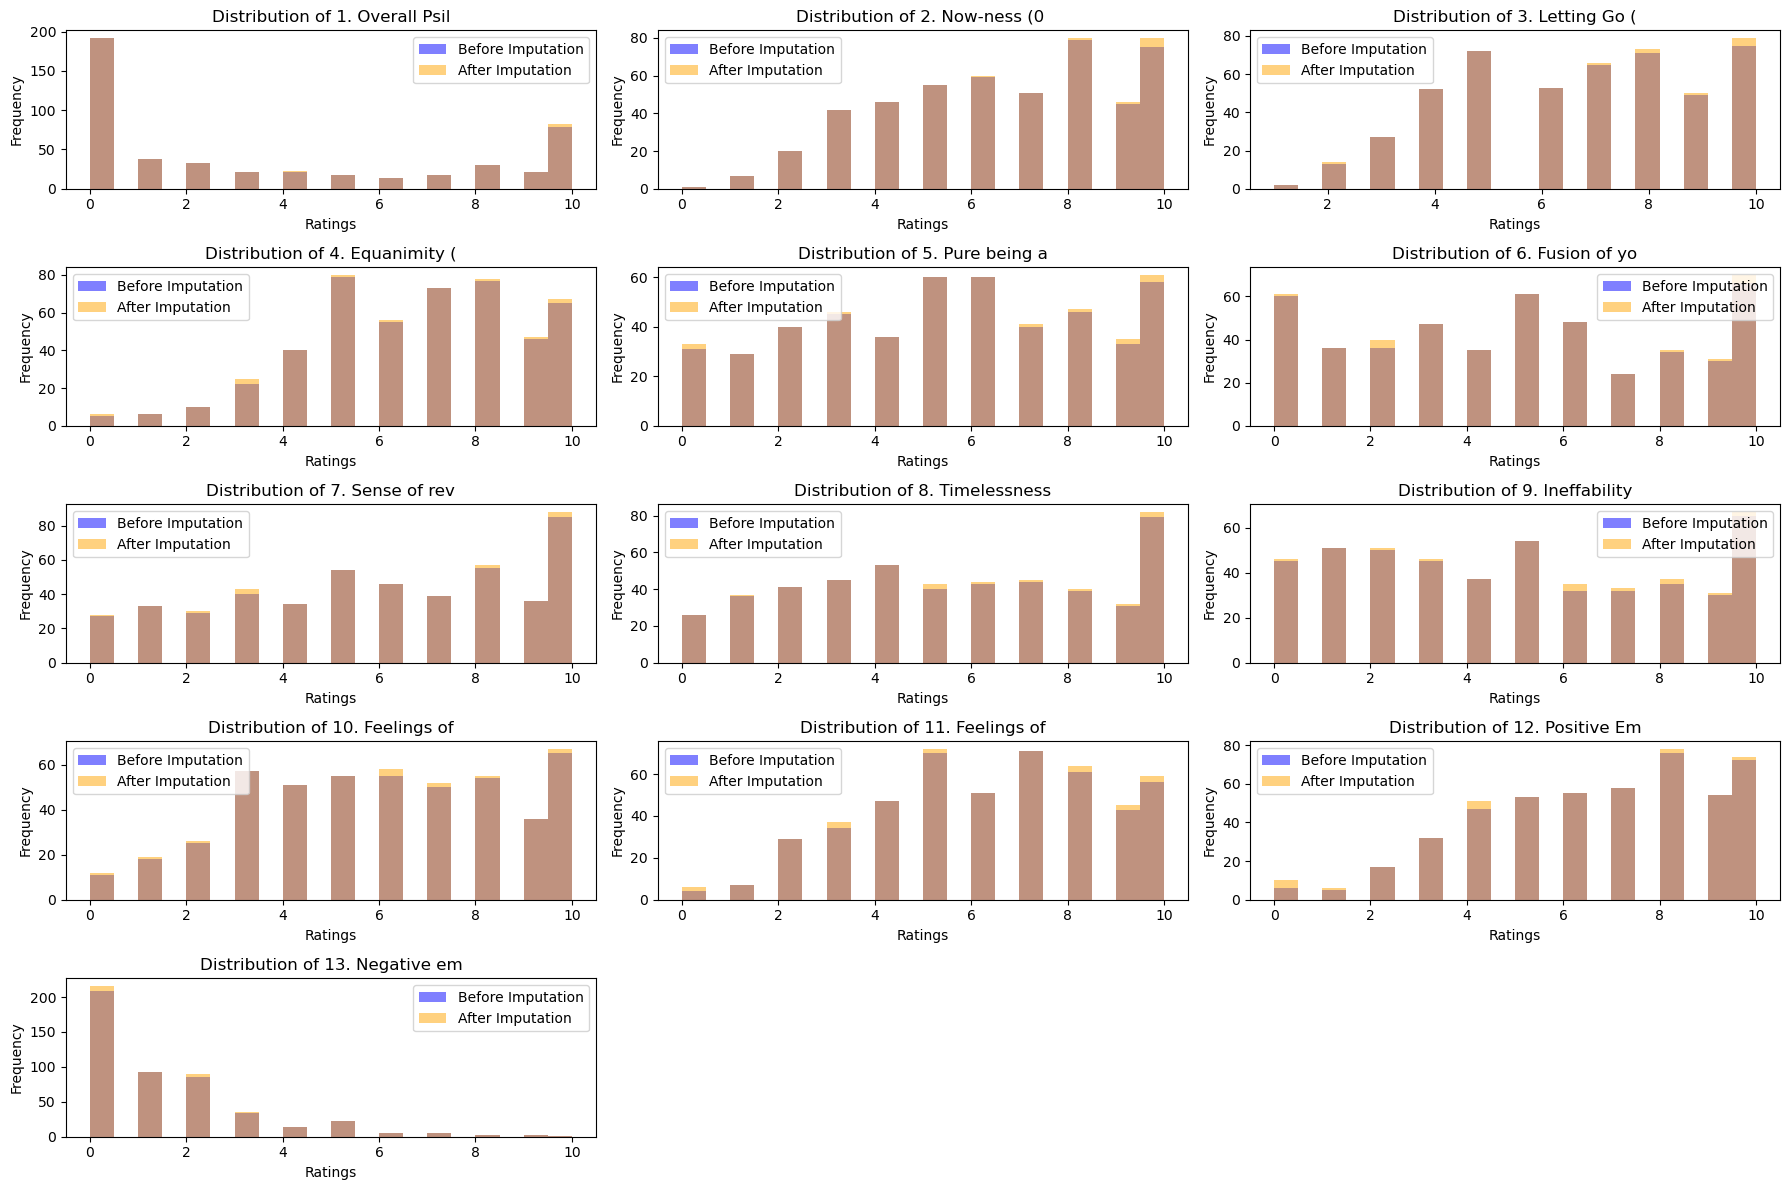

In [132]:
plt.figure(figsize=(12, 6))
plt.hist(df_cleaned['4. Equanimity (0 = none to\n10 = strongest imaginable)'], bins=20, alpha=0.5, label='Before Imputation')
plt.hist(df_cleaned_imputed['4. Equanimity (0 = none to\n10 = strongest imaginable)'], bins=20, alpha=0.5, label='After Imputation')
plt.xlabel('Equanimity Ratings')
plt.ylabel('Frequency')
plt.title('Comparison of Equanimity Ratings Before and After Imputation')
plt.legend()
plt.show

plt.figure(figsize=(18, 12))

for i, question in enumerate(rating_columns):
    plt.subplot(5, 3, i+1)
    plt.hist(df_cleaned[question], bins=20, alpha=0.5, label='Before Imputation', color='blue')
    plt.hist(df_cleaned_imputed[question], bins=20, alpha=0.5, label='After Imputation', color='orange')
    plt.title(f'Distribution of {question[:15]}')  # Truncate title for readability
    plt.xlabel('Ratings')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

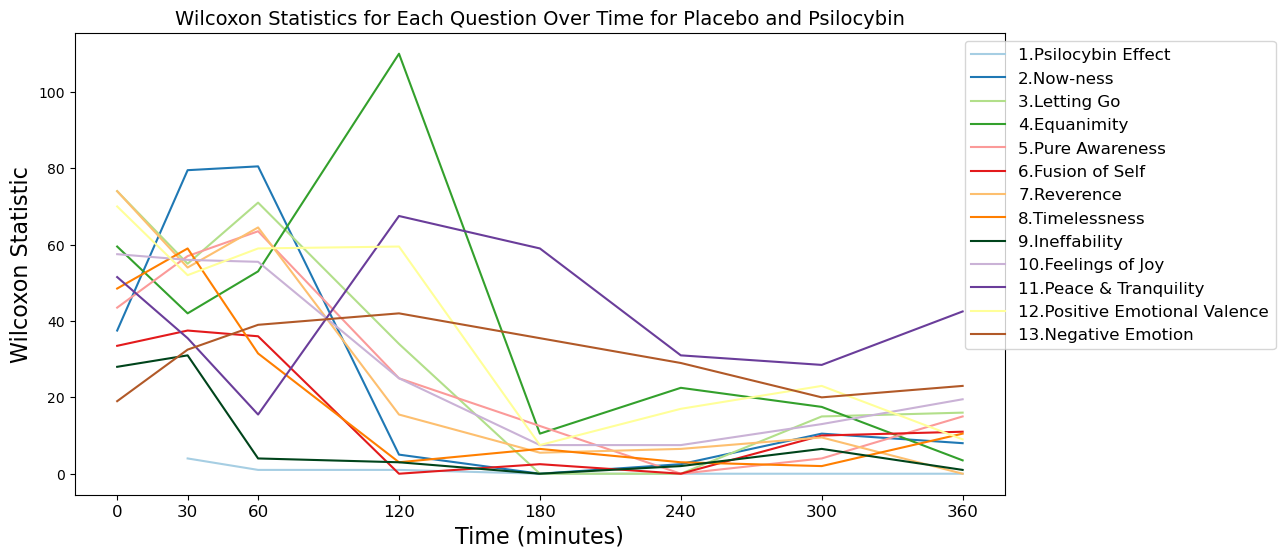

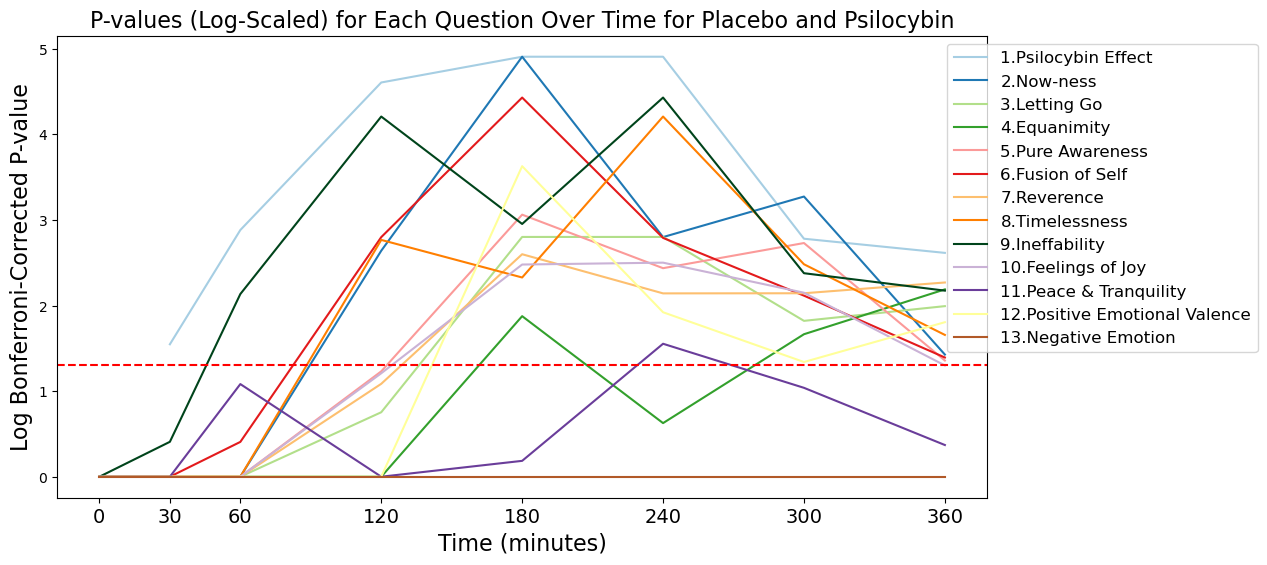

In [104]:
specific_timepoints = [0, 30, 60, 120, 180, 240, 300, 360]
custom_colors = [
    "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00",
    "#00441b", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928"
]

t_stats_by_question = {col: [] for col in rating_columns}
log_bonferroni_p_values_by_question = {col: [] for col in rating_columns}

# Extract Wilcoxon statistics and log Bonferroni p-values from paired_results_by_time
for timepoint in timepoints:
    for col in rating_columns:
        t_stat, log_p_value = paired_results_by_time[timepoint][col]
        t_stats_by_question[col].append(t_stat if t_stat is not None else np.nan)
        log_bonferroni_p_values_by_question[col].append(log_p_value if log_p_value is not None else np.nan)

# Plotting the Wilcoxon statistics over time
plt.figure(figsize=(12, 6))
for i, (col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, t_stats_by_question[col], label=short_col, color=custom_colors[i])
plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('Wilcoxon Statistic', fontsize=16)
plt.title('Wilcoxon Statistics for Each Question Over Time for Placebo and Psilocybin', fontsize=14)
plt.xticks(specific_timepoints, fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=12)
plt.show()

# Plotting the log Bonferroni-corrected p-values over time
plt.figure(figsize=(12, 6))
for i, (col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, log_bonferroni_p_values_by_question[col], label=short_col, color=custom_colors[i])
plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('Log Bonferroni-Corrected P-value', fontsize=16)
plt.title('P-values (Log-Scaled) for Each Question Over Time for Placebo and Psilocybin', fontsize=16)
plt.xticks(specific_timepoints, fontsize=14)
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--')  # Threshold for significance
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=12)
plt.show()


## Sections for Indepedent T Test

In [82]:
independent_results_by_time = {}
for timepoint in timepoints:
    df_timepoint = df_cleaned[df_cleaned['Timepoint relative to drug administration (in minutes)'] == timepoint]
    placebo_scores = df_timepoint[(df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA') & (df_timepoint['Session (1, 2)'] == 1)][rating_columns]
    psilocybin_scores = df_timepoint[(df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PSIL') & (df_timepoint['Session (1, 2)'] == 1)][rating_columns]
    independent_results_by_time[timepoint] = {}

    for col in rating_columns:
        if len(placebo_scores[col]) > 0 and len(psilocybin_scores[col]) > 0:  
            t_stat, p_value = stats.ttest_ind(placebo_scores[col], psilocybin_scores[col], nan_policy='omit')
            bonferroni_p_value = p_value * m
            if bonferroni_p_value > 1:  
                bonferroni_p_value = 1
            log_bonferroni_p_value = -np.log10(bonferroni_p_value) if bonferroni_p_value > 0 else 0
            if log_bonferroni_p_value == -0.0:
                log_bonferroni_p_value = 0
            independent_results_by_time[timepoint][col] = (t_stat, log_bonferroni_p_value) 
        else:
            independent_results_by_time[timepoint][col] = (None, None)  

    print(f"Results for Timepoint {timepoint} (minutes):")
    for col, (t_stat, log_bonferroni_p_value) in independent_results_by_time[timepoint].items():
        print(f"{col}: T-statistic = {t_stat}, Log Bonferroni P-value = {log_bonferroni_p_value}")
    print("\n")

Results for Timepoint 0 (minutes):
1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): T-statistic = nan, Log Bonferroni P-value = 0
2. Now-ness (0 = none to
10 = strongest imaginable): T-statistic = -0.010462094021844254, Log Bonferroni P-value = 0
3. Letting Go (0 = none to
10 = strongest imaginable): T-statistic = 0.4106802868547341, Log Bonferroni P-value = 0
4. Equanimity (0 = none to
10 = strongest imaginable): T-statistic = 0.4621971015345972, Log Bonferroni P-value = 0
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): T-statistic = -0.473218228828803, Log Bonferroni P-value = 0
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): T-statistic = -0.41198550354253083, Log Bonferroni P-value = 0
7. Sense of reverence or sacredness (0 = none to
10 = strongest imaginable): T-statistic = -0.9793048011484835, Log Bonferroni P-value = 0
8. Timelessness (0 = none to
10 = strongest imaginable): T-statistic =

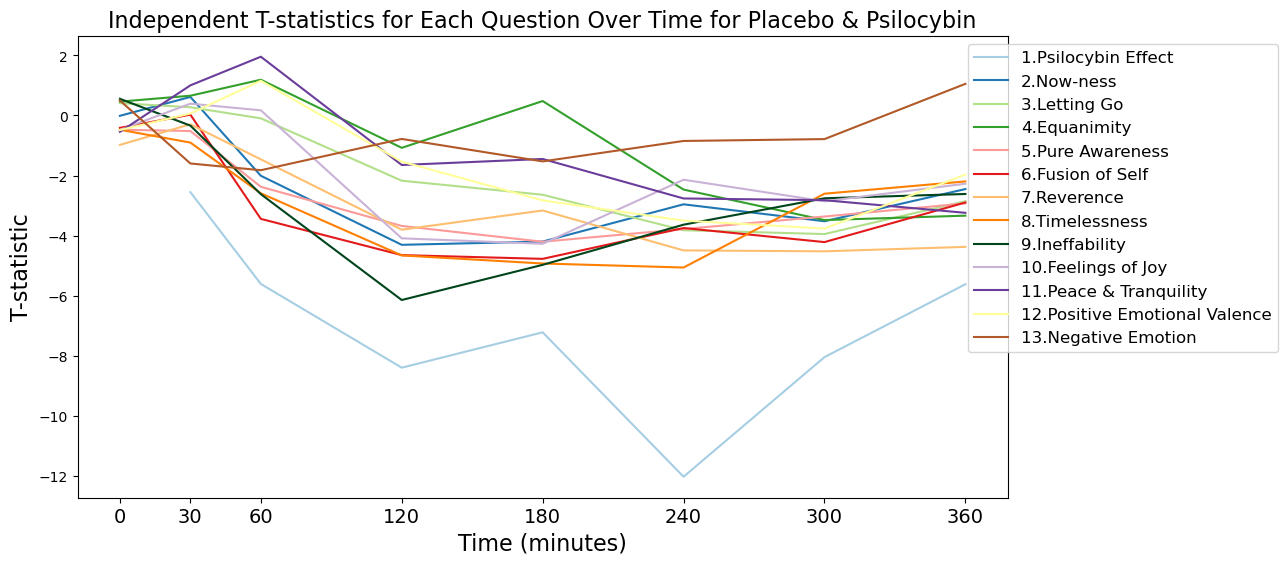

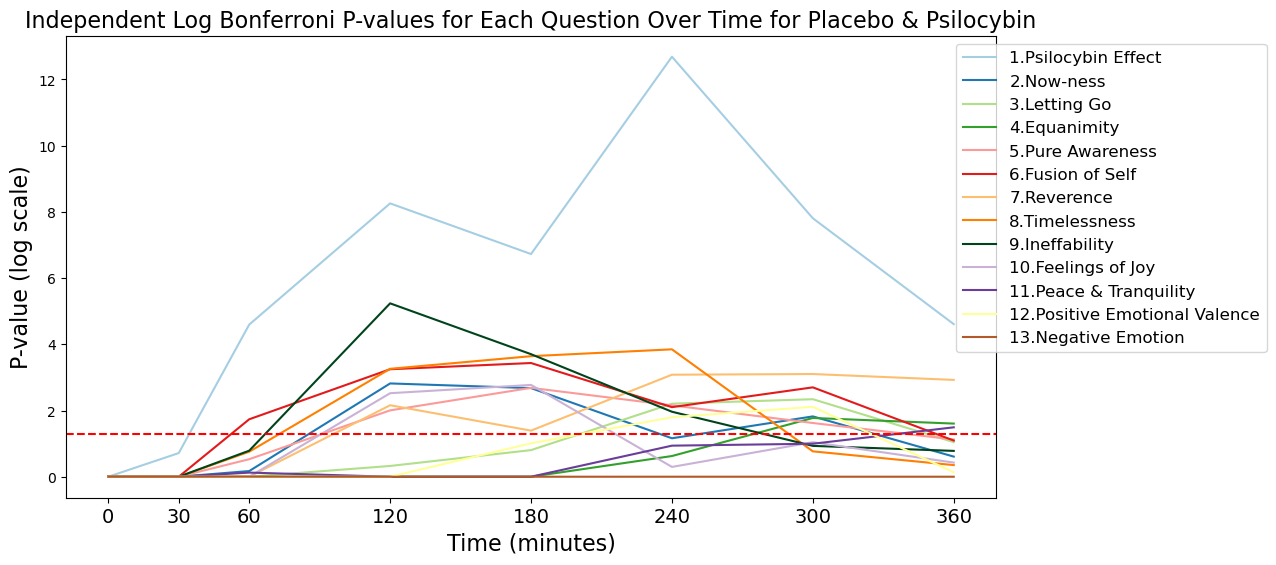

In [84]:
t_stats_by_question_independent = {col: [] for col in rating_columns}
log_p_value_by_question_independent = {col: [] for col in rating_columns}

# Extract T-statistics and log P-values from independent_results_by_time
for timepoint in timepoints:
    for col in rating_columns:
        t_stat, log_bonferroni_p_value = independent_results_by_time[timepoint][col]
        
        # Store T-statistics
        t_stats_by_question_independent[col].append(t_stat if t_stat is not None else np.nan)
        
        # Store log P-values
        log_p_value_by_question_independent[col].append(log_bonferroni_p_value if log_bonferroni_p_value is not None else np.nan)

# Plotting the T-statistics over time
plt.figure(figsize=(12, 6))
for i, (col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, t_stats_by_question_independent[col], label=short_col, color=custom_colors[i])
plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('T-statistic', fontsize=16)
plt.title('Independent T-statistics for Each Question Over Time for Placebo & Psilocybin', fontsize=16)
plt.xticks(specific_timepoints, fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=12)
plt.show()

# Plotting the log P-values over time
plt.figure(figsize=(12, 6))
for i, (col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, log_p_value_by_question_independent[col], label=short_col, color=custom_colors[i])
plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('P-value (log scale)', fontsize=16)
plt.title('Independent Log Bonferroni P-values for Each Question Over Time for Placebo & Psilocybin', fontsize=16)
plt.xticks(specific_timepoints, fontsize=14)
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--')  # Threshold for significance
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=12)
plt.show()

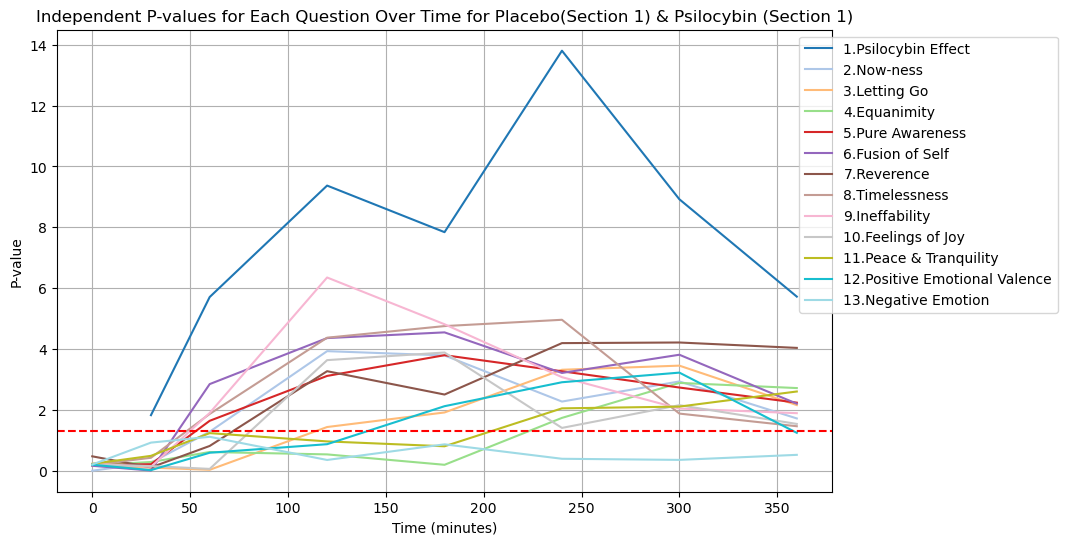

In [29]:
log_p_value_by_question_independent = {col: [] for col in rating_columns}

for timepoint in timepoints:
    for col in rating_columns:
        _, p_value = independent_results_by_time[timepoint][col]
        log_p_value_by_question_independent[col].append(p_value)

# Plot p-values for each question as a line plot
plt.figure(figsize=(10, 6))
#for col in rating_columns:
    #plt.plot(timepoints, p_value_by_question_independent[col], label=col)
for i,(col, short_col) in enumerate(zip(rating_columns, shortened_rating_columns)):
    plt.plot(timepoints, log_p_value_by_question_independent[col], label=short_col,color=cmap(i))
plt.xlabel('Time (minutes)')
plt.ylabel('P-value')
plt.title('Independent P-values for Each Question Over Time for Placebo(Section 1) & Psilocybin (Section 1)')
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--')  
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()

## Data Exploration

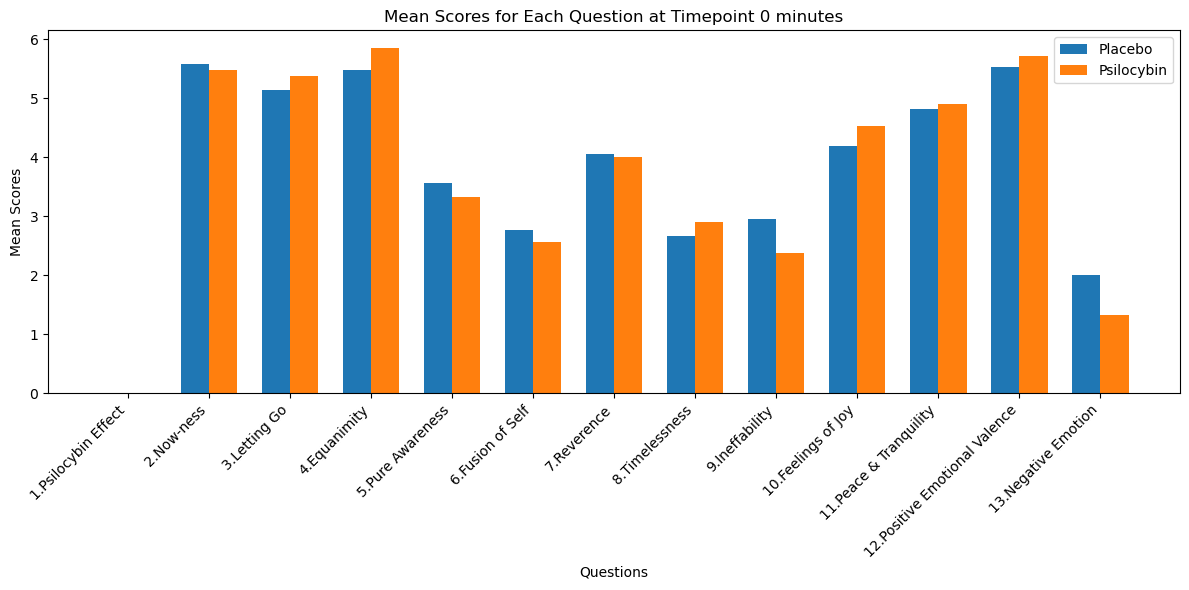

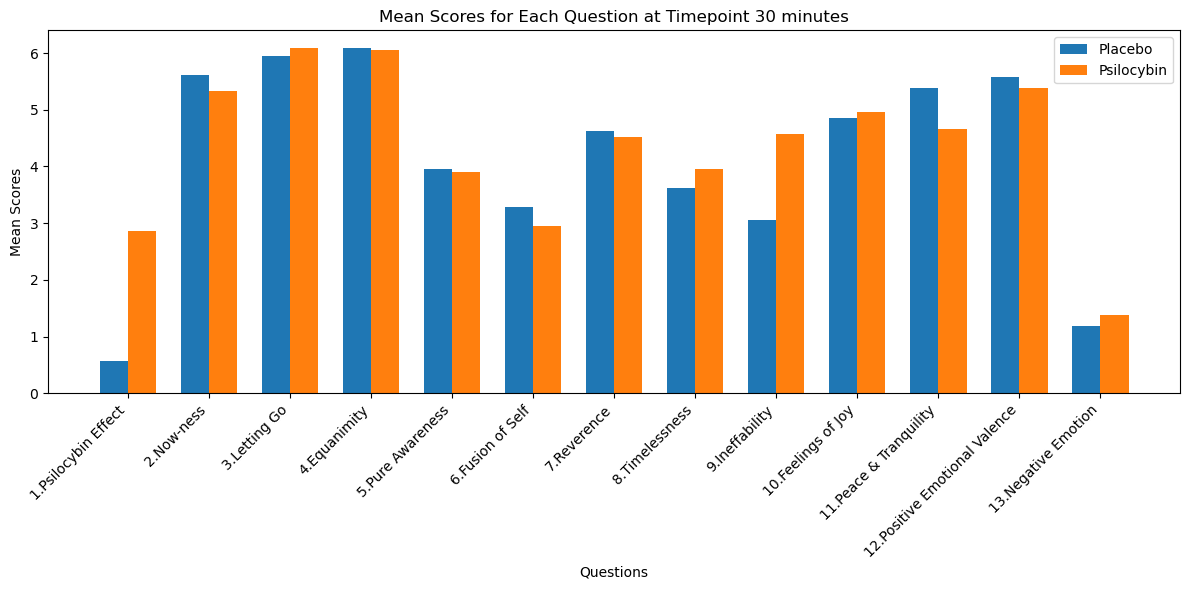

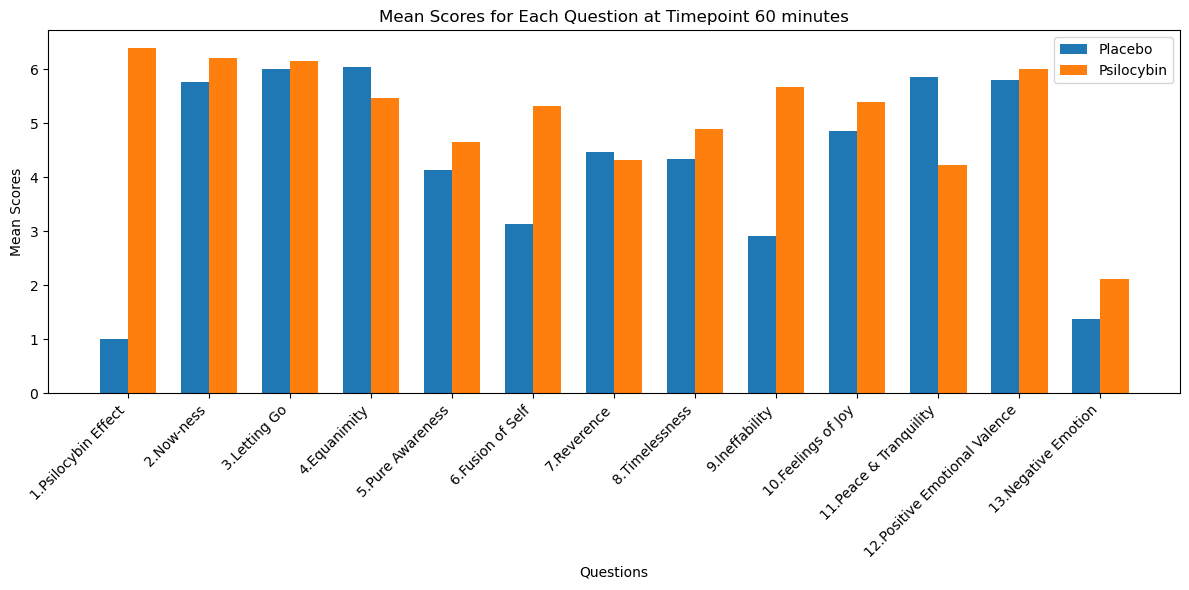

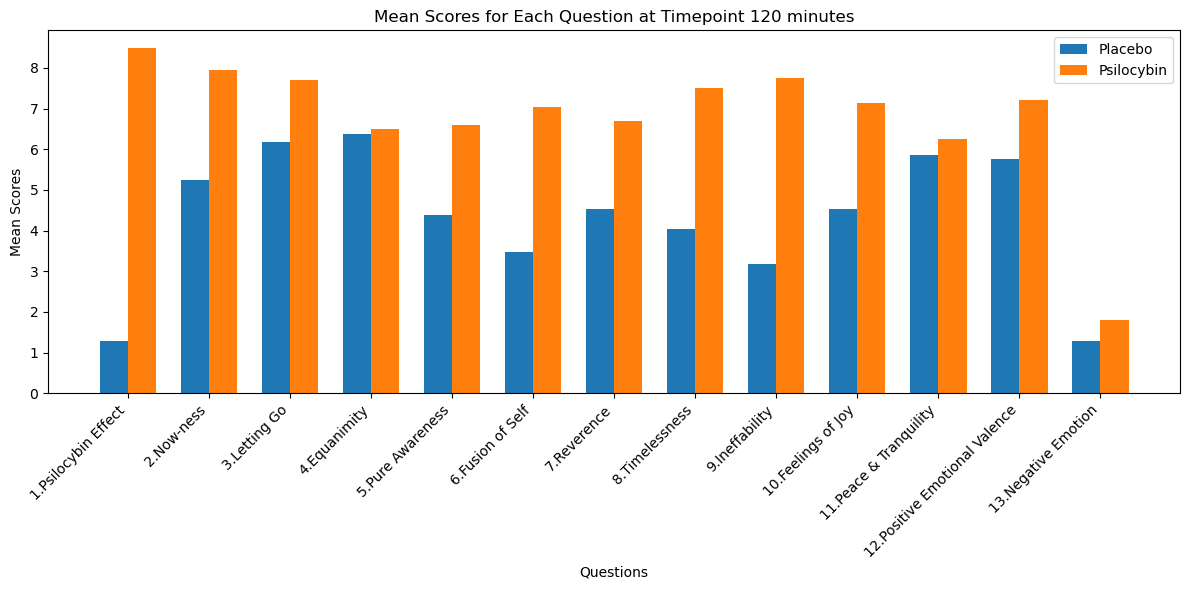

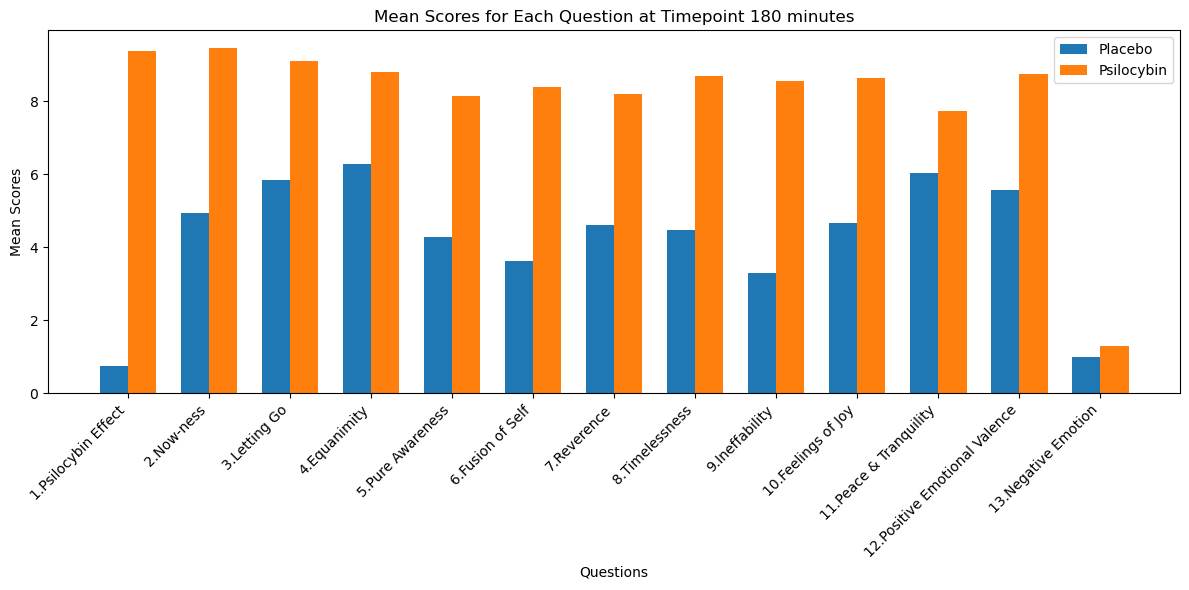

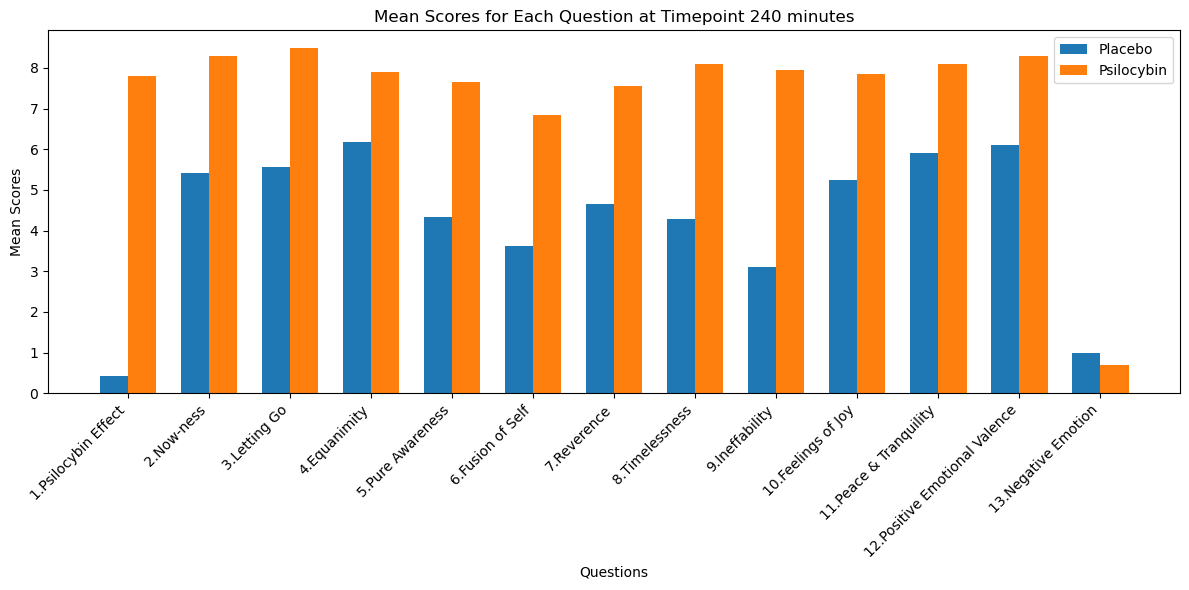

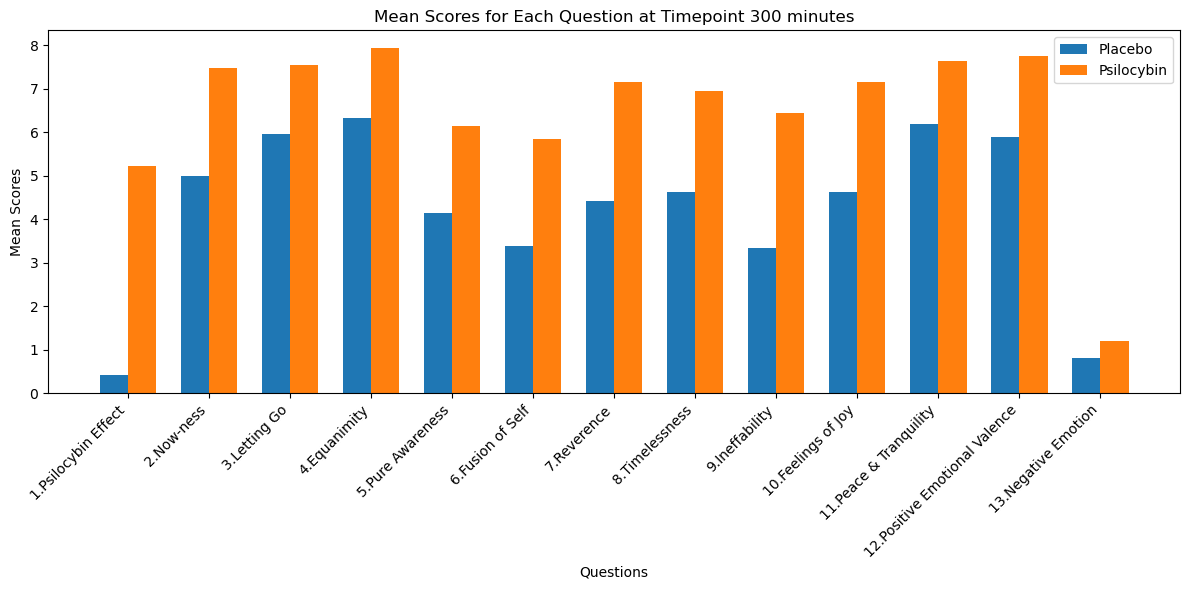

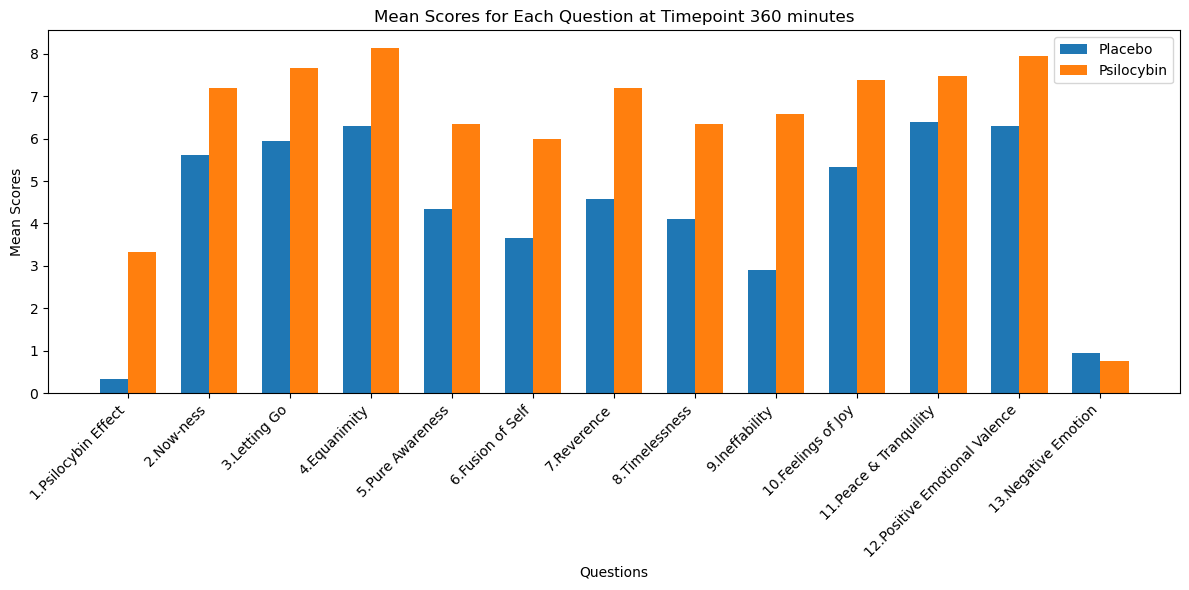

In [33]:
for timepoint in timepoints:
    # Filter data for the current timepoint and section 1
    df_timepoint = df_cleaned[df_cleaned['Timepoint relative to drug administration (in minutes)'] == timepoint]

    df_placebo = df_timepoint[(df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA') & (df_timepoint['Session (1, 2)'] == 1)]
    df_exp = df_timepoint[(df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'EXP') & (df_timepoint['Session (1, 2)'] == 2)]
    
    placebo_means = df_placebo[rating_columns].mean()
    exp_means = df_exp[rating_columns].mean()

    # Create a bar plot
    x = np.arange(len(rating_columns))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Bar plot for placebo and psilocybin
    ax.bar(x - width/2, placebo_means, width, label='Placebo')
    ax.bar(x + width/2, exp_means, width, label='Psilocybin')

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Questions')
    ax.set_ylabel('Mean Scores')
    ax.set_title(f'Mean Scores for Each Question at Timepoint {timepoint} minutes')
    ax.set_xticks(x)
    ax.set_xticklabels(shortened_rating_columns, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()

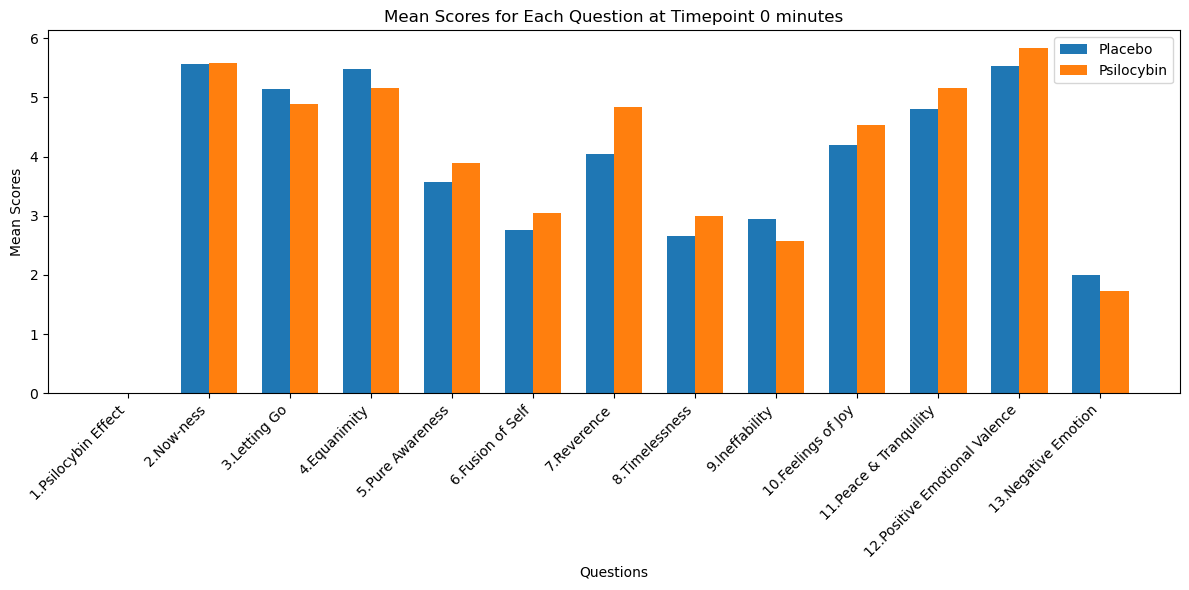

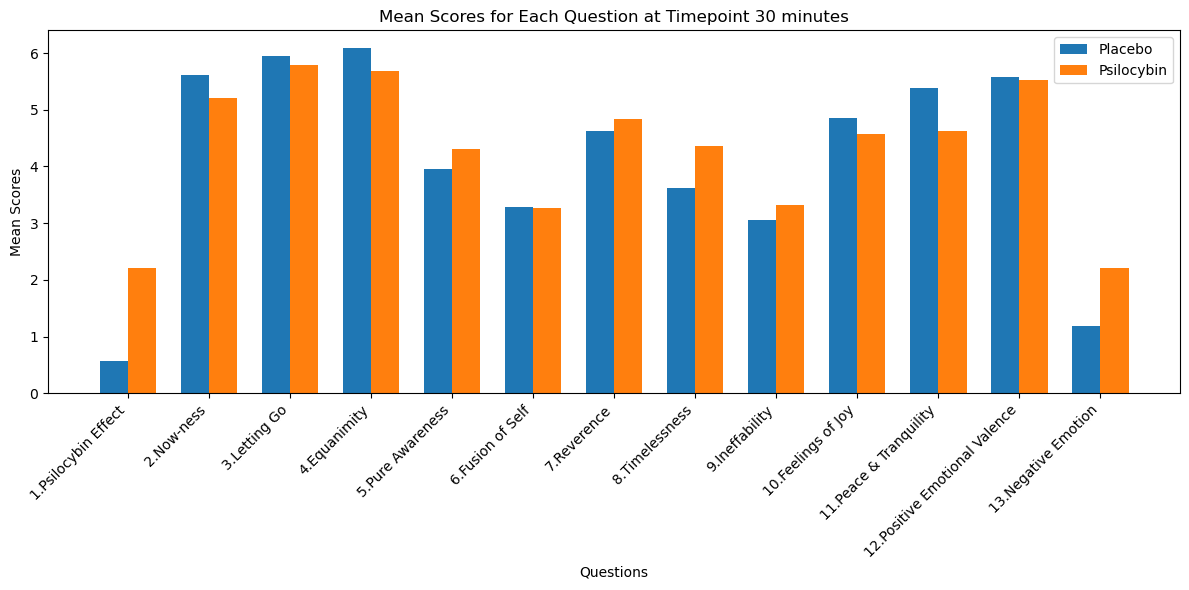

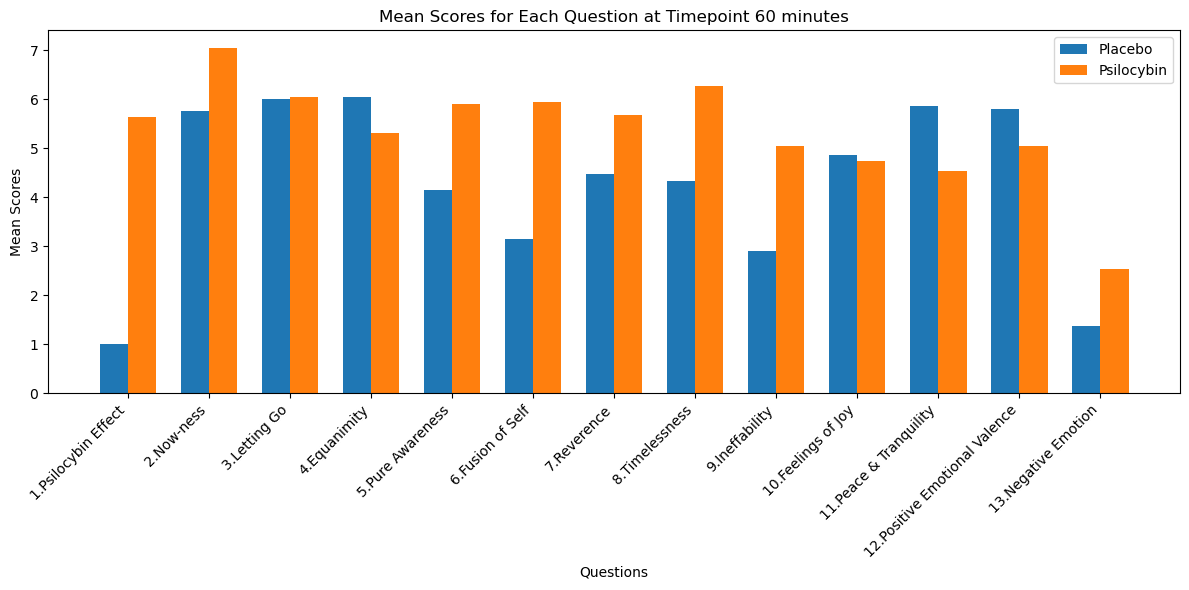

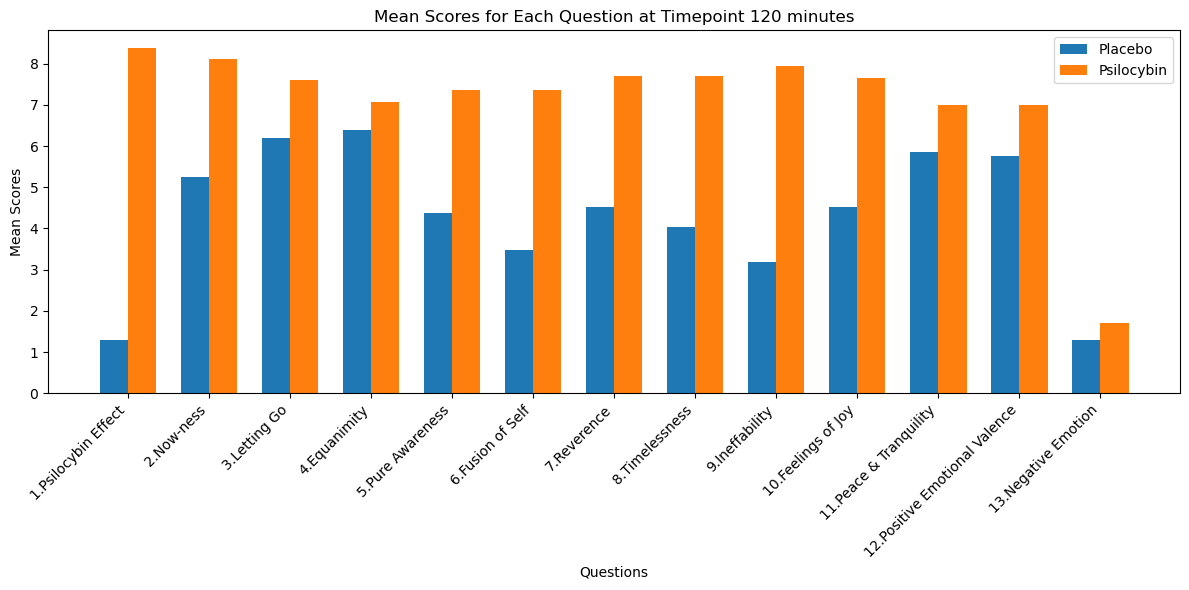

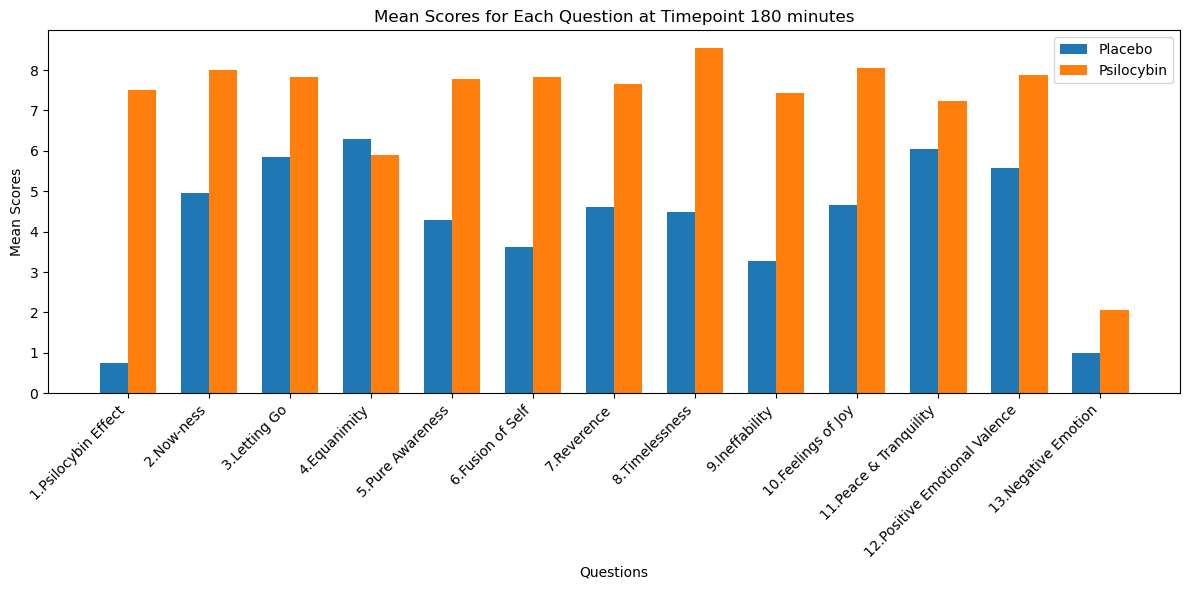

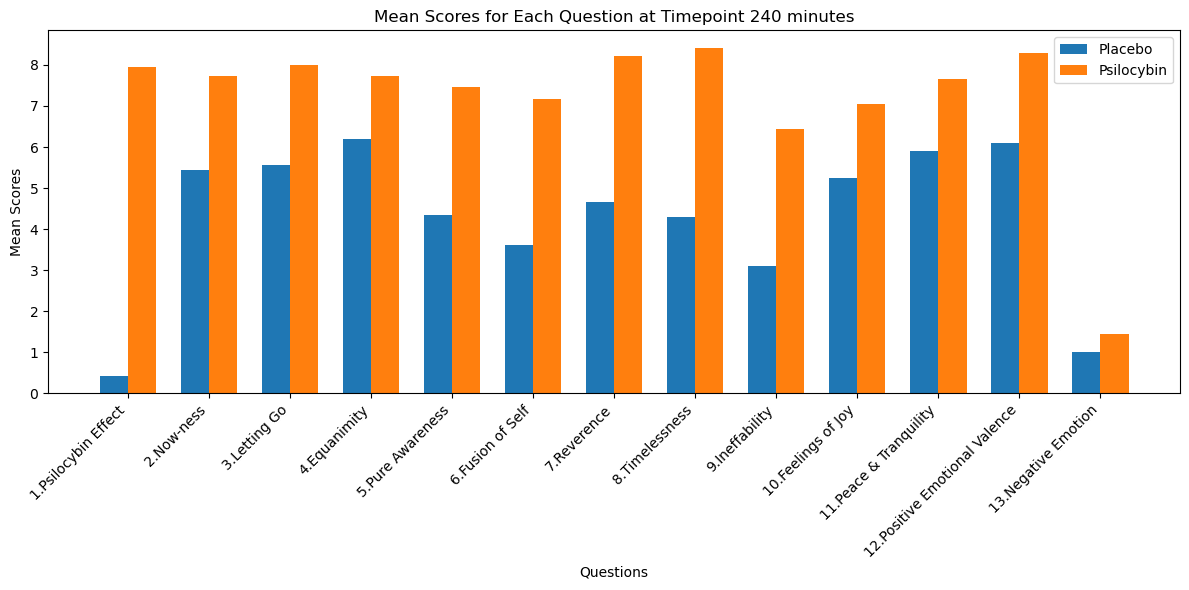

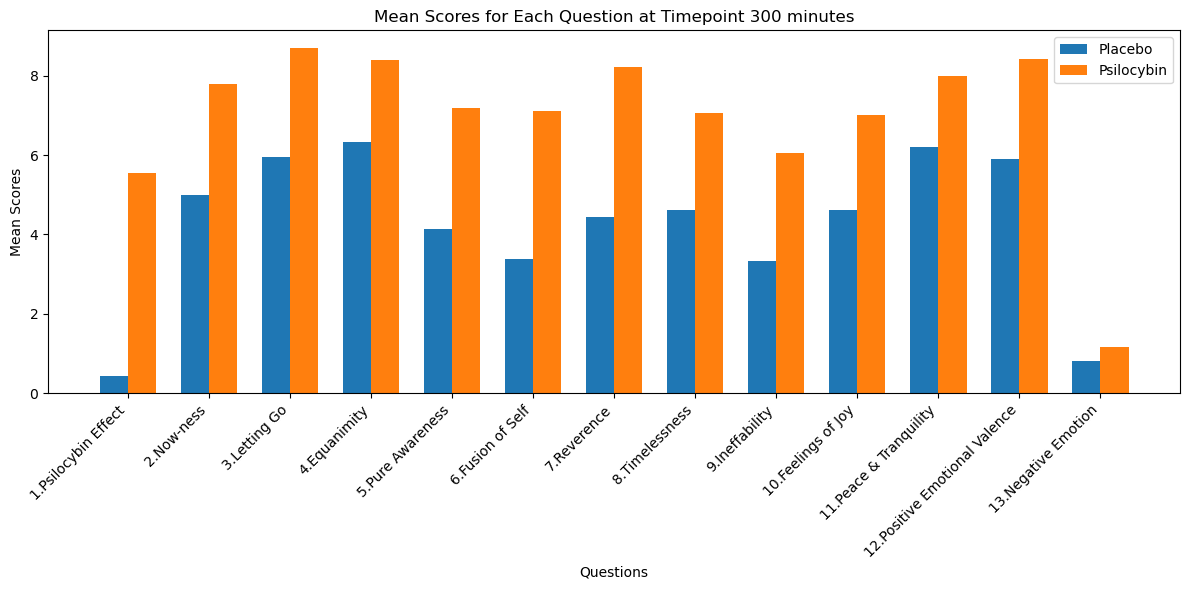

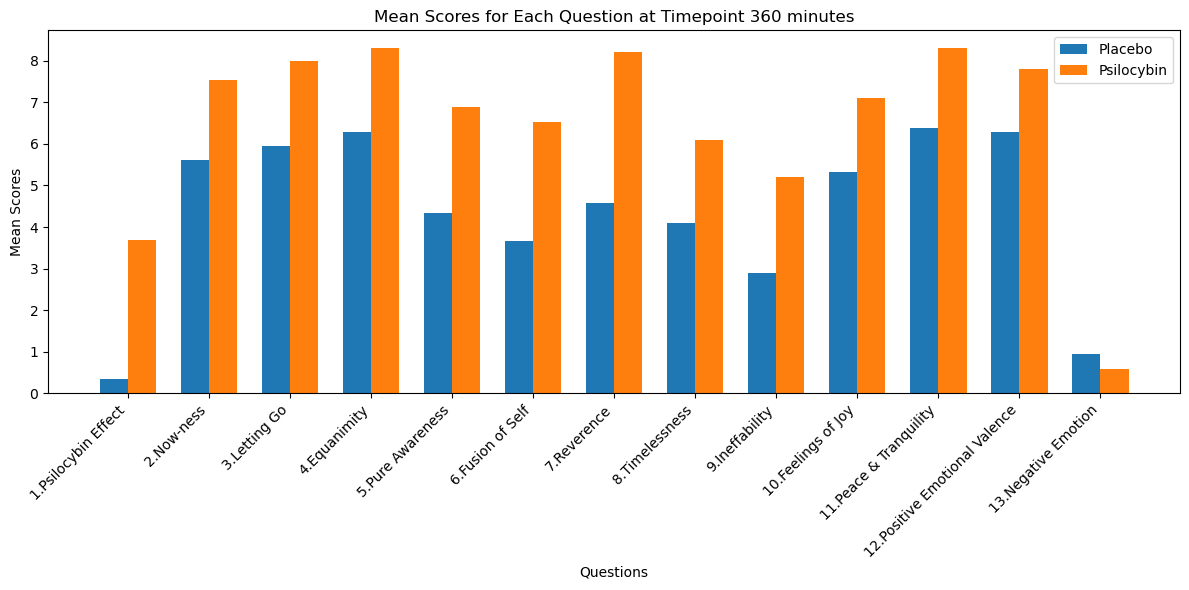

In [34]:
for timepoint in timepoints:
    df_timepoint = df_cleaned[df_cleaned['Timepoint relative to drug administration (in minutes)'] == timepoint]
    df_placebo = df_timepoint[(df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA') & (df_timepoint['Session (1, 2)'] == 1)]
    df_psilocybin = df_timepoint[(df_timepoint['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PSIL') & (df_timepoint['Session (1, 2)'] == 1)]

    placebo_means = df_placebo[rating_columns].mean()
    psilocybin_means = df_psilocybin[rating_columns].mean()

    x = np.arange(len(rating_columns))
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.bar(x - width/2, placebo_means, width, label='Placebo')
    ax.bar(x + width/2, psilocybin_means, width, label='Psilocybin')

    ax.set_xlabel('Questions')
    ax.set_ylabel('Mean Scores')
    ax.set_title(f'Mean Scores for Each Question at Timepoint {timepoint} minutes')
    ax.set_xticks(x)
    ax.set_xticklabels(shortened_rating_columns, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()

In [36]:
df[rating_columns] = df[rating_columns].apply(pd.to_numeric, errors='coerce')

In [39]:
session_1 = df[df['Session (1, 2)'] == 1]
session_2 = df[df['Session (1, 2)'] == 2]
crossover_participants = session_1[(session_1['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA')]

In [41]:
results_paired = {}
for col in rating_columns:
    placebo_scores = session_1[session_1['Volunteer number'].isin(crossover_participants['Volunteer number'])][col]
    psilocybin_scores = session_2[session_2['Volunteer number'].isin(crossover_participants['Volunteer number'])][col]
        # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(placebo_scores, psilocybin_scores, nan_policy='omit')
    results_paired[col] = (t_stat, p_value)

for col, (t_stat, p_value) in results_paired.items():
    print(f"{col}: T-statistic = {t_stat}, P-value = {p_value}")

ValueError: unequal length arrays

For the participants who received placebo in session 1 and were crossed over to psilocybin in session 2,  a paired t-test was performed for each subjective rating variable. This test was performed to determine if there was a significant difference in responses before and after the crossover from placebo to psilocybin.
The results indicated significant differences between conditions for most variables, such as "Overall Psilocybin Effect", "Now-ness", "Letting Go", and others, with extremely low p-values, implying strong statistical significance.

In [43]:
psilocybin_only = session_1[session_1['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PSIL']
placebo_only = session_1[session_1['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'] == 'PLA']
#for col in rating_columns:
   #print(f"{col}: {placebo_only[col].isna().sum()} missing values in placebo group")
   #print(f"{col}: {psilocybin_only[col].isna().sum()} missing values in psilocybin group")
placebo_only_cleaned = placebo_only.dropna(subset=rating_columns)
psilocybin_only_cleaned = psilocybin_only.dropna(subset=rating_columns)
#print(placebo_only.shape)
#print(placebo_only_cleaned.shape)

In [45]:
results_independent = {}
for col in rating_columns:
    placebo_scores = placebo_only[col]
    psilocybin_scores = psilocybin_only[col]
    
    # Perform the two-sample t-test
    t_stat, p_value = stats.ttest_ind(placebo_scores, psilocybin_scores, nan_policy='omit')
    results_independent[col] = (t_stat, p_value)

for col, (t_stat, p_value) in results_independent.items():
    print(f"{col}: T-statistic = {t_stat}, P-value = {p_value}")

1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): T-statistic = -15.429444401377932, P-value = 1.82996864804383e-41
2. Now-ness (0 = none to
10 = strongest imaginable): T-statistic = -5.807565754223764, P-value = 1.408653081980698e-08
3. Letting Go (0 = none to
10 = strongest imaginable): T-statistic = -3.4222356395405535, P-value = 0.000693751208854987
4. Equanimity (0 = none to
10 = strongest imaginable): T-statistic = -1.0788089163713, P-value = 0.28140743509900423
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): T-statistic = -7.920759406904275, P-value = 3.10622139867374e-14
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): T-statistic = -8.695702299863871, P-value = 1.322030541783588e-16
7. Sense of reverence or sacredness (0 = none to
10 = strongest imaginable): T-statistic = -8.321093126288845, P-value = 1.9135481802495092e-15
8. Timelessness (0 = none to
10 = strongest imaginable): T-statis

In [47]:
for col in rating_columns:
    placebo_scores = placebo_only_cleaned[col]
    psilocybin_scores = psilocybin_only_cleaned[col]
    t_stat, p_value = stats.ttest_ind(placebo_scores, psilocybin_scores, nan_policy='omit')
    results_independent[col] = (t_stat, p_value)

for col, (t_stat, p_value) in results_independent.items():
    print(f"{col}: T-statistic = {t_stat}, P-value = {p_value}")

1. Overall Psilocybin Effect (0 = none to
10 = strongest imaginable): T-statistic = -15.121591921917284, P-value = 3.919616204202543e-40
2. Now-ness (0 = none to
10 = strongest imaginable): T-statistic = -5.7045505543911155, P-value = 2.480418165038184e-08
3. Letting Go (0 = none to
10 = strongest imaginable): T-statistic = -3.2329655931459844, P-value = 0.0013412746126078713
4. Equanimity (0 = none to
10 = strongest imaginable): T-statistic = -0.9192942150934472, P-value = 0.35857301622430715
5. Pure being and pure awareness (0 = none to
10 = strongest imaginable): T-statistic = -7.7813754952725285, P-value = 8.100984271662408e-14
6. Fusion of your personal self into a larger whole (0 = none to
10 = strongest imaginable): T-statistic = -8.56778916092202, P-value = 3.387383170660452e-16
7. Sense of reverence or sacredness (0 = none to
10 = strongest imaginable): T-statistic = -8.094743032561867, P-value = 9.520313653651218e-15
8. Timelessness (0 = none to
10 = strongest imaginable): T-

 an independent t-test for participants who received either psilocybin or placebo in session 1, comparing these two groups. This test was first conducted with missing data and later with cleaned data (remove NaN).For the cleaned data, you found significant differences between the psilocybin and placebo groups across several variables, including "Overall Psilocybin Effect", "Letting Go", "Sense of reverence or sacredness", and others, with p-values showing strong statistical significance (e.g., p-values < 0.001)

Both the paired and independent t-tests indicated that psilocybin had a statistically significant effect on participants' subjective experiences when compared to placebo. 

## Trying Lazy Predict

In [95]:
!pip install opendatasets --upgrade --quiet
!pip3 install lazypredict 
!pip3 install graphviz

In [103]:

import os
import numpy as np
import pandas as pd
import opendatasets as od
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # for Random Forest Classifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [112]:
X = df[rating_columns]  
y = df['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)']

In [114]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and predict
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# View results
print(models)

100%|██████████| 31/31 [00:03<00:00, 10.29it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 488, number of used features: 8
[LightGBM] [Info] Start training from score -1.025529
[LightGBM] [Info] Start training from score -1.042821
[LightGBM] [Info] Start training from score -1.241556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

## Some Random PCA I done

In [116]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [146]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df[rating_columns]) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [172]:
pca = PCA(n_components=X_scaled.shape[1]) 
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)
print("Total Variance Explained by 2 components:", sum(explained_variance))

Explained Variance Ratio: [0.62776203 0.14278614 0.0789812  0.04592319 0.03807703 0.02993752
 0.01986962 0.01666328]
Total Variance Explained by 2 components: 0.9999999999999999


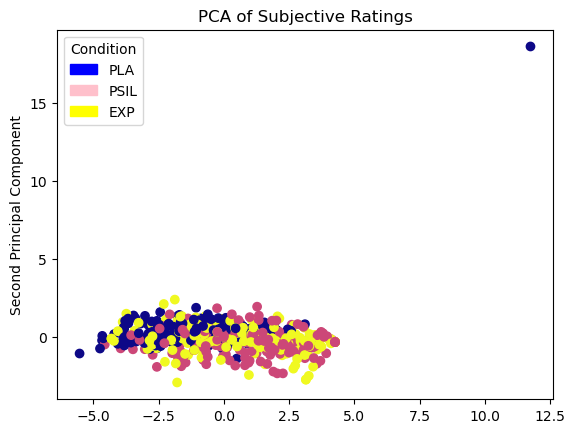

In [206]:
import matplotlib.patches as mpatches
df['Condition_encoded'] = df['Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)'].map({'PLA': 0, 'PSIL': 1, 'EXP':2})

# Use the encoded values for the 'c' argument
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Condition_encoded'], cmap='plasma')
plt.ylabel('Second Principal Component')
plt.title('PCA of Subjective Ratings')
legend_handles = [mpatches.Patch(color='blue', label='PLA'),
                  mpatches.Patch(color='pink', label='PSIL'),
                  mpatches.Patch(color='yellow', label='EXP')]
plt.legend(handles=legend_handles, title='Condition')
plt.show()

In [208]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=X_scaled.shape[1], random_state=42)
X_ica = ica.fit_transform(X_scaled)


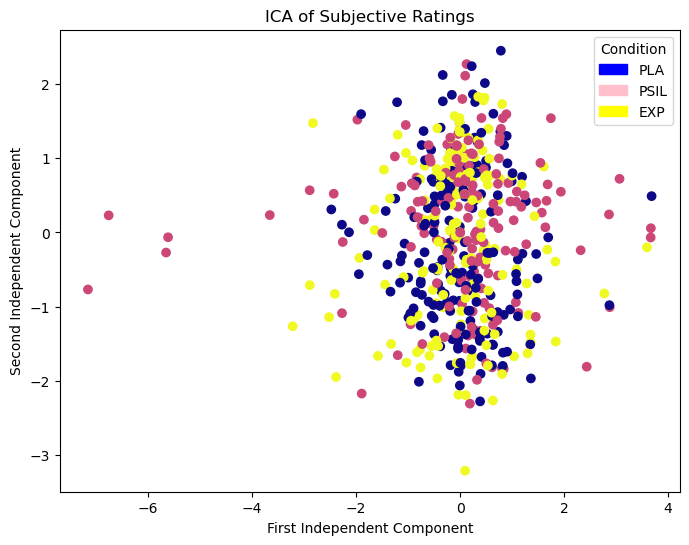

In [216]:
plt.figure(figsize=(8, 6))
plt.scatter(X_ica[:, 0], X_ica[:, 1], c=df['Condition_encoded'], cmap='plasma')
plt.xlabel('First Independent Component')
plt.ylabel('Second Independent Component')
plt.title('ICA of Subjective Ratings')
#plt.colorbar(label='Condition (PLA, PSIL, EXP)')
nd_handles = [mpatches.Patch(color='blue', label='PLA'),
                  mpatches.Patch(color='pink', label='PSIL'),
                  mpatches.Patch(color='yellow', label='EXP')]
plt.legend(handles=legend_handles, title='Condition')
plt.show()